# ghg_analytics
## Insights into trends with global greenhouse gases and climate change action.

EPA1333 – Computer Engineering for Scientific Computing Final Project

### Authors
Group 6:
* Aashna Mittal
* Gamze Ünlü
* Jason R Wang

## Introduction

Anthropogenic climate change was first introduced into the global political arena as the United Nations Framework on Climate Change Convention (UNFCCC) in 1992. Since then, other international agreements have continued to refine mitigation action.

At 19th Conference of the Parties (to the UNFCCC) in 2013 in Warsaw, the UNFCCC members agreed to submit "Intended Nationally Determined Contributions" (INDCs) to signal what each country's greenhouse gas emission targets would be. At the 21st Conference in 2015, the Paris Agreement formalized these _intended_ emissions into simply "Nationally Determined Contributions" (NDCs).

Furthermore, the signatories to the Paris Agreement (which includes all UNFCCC signatories, and therefore, all UN member nations) have agreed to maintain global warming to 2ºC, but preferrably 1.5ºC, above pre-industrial levels. This Notebook intends to analyze the NDCs to estimate their potential to reach these temperature goals.

In [1]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
plt.style.use('ggplot')

## 1. NDCs and Temperature Targets

To determine the impact of NDCs, we need to first understand their context by answering the following questions:
1. What do global emissions look like today?
2. If nothing changes, and the world continues doing _business as usual_ (BAU), how will the world look like in 2030?

Then, we can examine how NDCs compare:
3. If all NDCs are met, what will the total amount of emissions be?
4. What emission amounts are required to meet temperature targets?

Finally, all of this will be compared in 1.5.

_Note: Emissions are quantified in units of 'megatons of carbon dioxide-equivalent per year' [MtCO2e/yr] because the strength all greenhouse gases are measured relative to carbon dioxide and because the carbon cycle is a process. Global climate targets assume that natural GHG uptake will continue steadily, so reducing the rate of emissions from countries will lead to a net decrease in the concentration of GHGs in the atmosphere._

### 1.1 Current Greenhouse Gas Emissions

The World Bank and the World Resources Institute both maintain databases of current GHG emissions. The primary data source is from the UNFCCC's reporting window; each UNFCCC member submits annual 'GHG Inventories', which track national emissions with two-year delay.

First examine WB data, which holds GHGs in ktCO2e, includes natural emissions, and has data from 1970-2012 and uses global warming potentials from the IPCC AR2 report.
    
Source: https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE?view=chart

In [2]:
# Import World Bank data on GHGs
ghgDf_WBoriginal = pd.read_csv("data/GreenhouseGasData.csv", sep=',', skipinitialspace=True, skiprows=4, index_col=0) 

# Drop the indicator name and indicator code as the values are same across the whole dataframe
ghgDf_WB = ghgDf_WBoriginal.drop(["Indicator Code", "Indicator Name"], axis = 1)

# Drop all the columns that contain only null values
ghgDf_WB.dropna(axis = 1, how="all", inplace=True)  

# Drop all the rows that contain only null values, starting from column 2
ghgDf_WB.dropna(axis = 0, how="all", subset = ghgDf_WB.columns[2:], inplace= True)  

# Interpolate missing values and then use backfill to fill starting NA values of a row
ghgDf_WB.iloc[:,2:] = ghgDf_WB.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

# Convert all emissions data into MtCO2e
ghgDf_WB.iloc[:,1:] = ghgDf_WB.iloc[:,1:].divide(1000)

In [3]:
# View the cleaned WB GHG DataFrame
ghgDf_WB.head()

,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,0.042306,0.042787,0.043287,0.043725,0.044131,0.044482,0.131634,0.135055,0.358990,...,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929
Afghanistan,AFG,14.306616,14.391778,13.040848,13.535754,14.945968,14.574164,14.746851,15.247281,15.112318,...,14.709884,14.654374,14.770264,14.849159,15.272633,15.288776,15.554429,17.791330,17.981307,18.168860
Angola,AGO,60.648601,39.162171,42.205651,44.252669,40.179234,44.429300,38.448024,43.563412,46.235115,...,35.858015,36.860233,35.855738,36.375822,36.690534,37.396294,38.309465,40.029392,40.878652,41.657165
Albania,ALB,6.960868,6.950036,7.613266,7.348492,7.632664,7.873037,8.470978,8.948981,9.996056,...,7.834016,7.401102,8.308386,8.027150,9.879394,8.136785,8.108812,8.506996,8.712296,8.898641
Arab World,ARB,552.362062,576.946152,625.015944,699.280217,679.448006,683.966235,775.863730,799.971041,827.155739,...,1963.193015,1660.586949,1767.878645,1731.288792,2355.481347,2364.088663,2387.502011,1924.244973,2483.349104,1908.696042


Next, add the CAIT data, since it has 2013 and 2014.

In [4]:
# GHGs from 2013 and 2014
ghgDf_CAITghg = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017.xlsx",
                               sep=',', sheet_name='GHG Emissions', skipinitialspace=True, skiprows=1, index_col=0)

# CO2 emissions from 1850
ghgDf_CAITco2 = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017.xlsx",
                               sep=',', sheet_name='CO2 Total Emissions', skipinitialspace=True, index_col=0).dropna()

Filter and clean just the 2013 and 2014 years that we want and the section that we want

In [5]:
ghgDf_CAITghg1314 = ghgDf_CAITghg[ (ghgDf_CAITghg['Year'] == 2013) | (ghgDf_CAITghg['Year'] == 2014) ]\
    .loc[:,['Year','Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)']]

# Pivot the table to be in the same format as the World Bank data, which is in a nicer format
# (since we are only looking at total emissions).
ghgDf_CAITghg1314 = ghgDf_CAITghg1314.pivot(columns='Year',
                  values='Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)')

ghgDf_CAITghg1314.head()

Year,2013,2014
Country,,
Afghanistan,33.170920,33.366148
Albania,8.199265,8.678753
Algeria,187.088061,201.685126
Andorra,0.509704,0.496379
Angola,270.339084,252.092930


In [6]:
# Combine filtered CAIT data with the World Bank's dataset

# First, check to see if all the country names match! These countries are not:
ghgDf_CAITghg1314.index[~ghgDf_CAITghg1314.index.isin(ghgDf_WB.index)]

######## Match Countries! ########

Index(['Andorra', 'Antigua & Barbuda', 'Bahamas', 'Bosnia & Herzegovina',
       'Brunei', 'Cape Verde', 'Congo', 'Congo, Dem. Republic', 'Cook Islands',
       'Egypt', 'European Union (28)', 'Gambia', 'Iran', 'Korea (North)',
       'Korea (South)', 'Kyrgyzstan', 'Laos', 'Liechtenstein', 'Micronesia',
       'Montenegro', 'Nauru', 'Niue', 'Palau', 'Saint Kitts & Nevis',
       'Saint Lucia', 'Saint Vincent & Grenadines', 'Sao Tome & Principe',
       'Serbia', 'Slovakia', 'Swaziland', 'Syria', 'Trinidad & Tobago',
       'United States of America', 'Venezuela', 'Yemen'],
      dtype='object', name='Country')

In [7]:
ghgDf_WB.index[~ghgDf_WB.index.isin(ghgDf_CAITghg1314)]

Index(['Aruba', 'Afghanistan', 'Angola', 'Albania', 'Arab World',
       'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa',
       'Antigua and Barbuda',
       ...
       'British Virgin Islands', 'Virgin Islands (U.S.)', 'Vietnam', 'Vanuatu',
       'World', 'Samoa', 'Yemen, Rep.', 'South Africa', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country Name', length=245)

In [8]:
ghgDf_merged = ghgDf_WB.join(ghgDf_CAITghg1314)
ghgDf_merged.head()

,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,0.042306,0.042787,0.043287,0.043725,0.044131,0.044482,0.131634,0.135055,0.358990,...,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,NaN,NaN
Afghanistan,AFG,14.306616,14.391778,13.040848,13.535754,14.945968,14.574164,14.746851,15.247281,15.112318,...,14.770264,14.849159,15.272633,15.288776,15.554429,17.791330,17.981307,18.168860,33.170920,33.366148
Angola,AGO,60.648601,39.162171,42.205651,44.252669,40.179234,44.429300,38.448024,43.563412,46.235115,...,35.855738,36.375822,36.690534,37.396294,38.309465,40.029392,40.878652,41.657165,270.339084,252.092930
Albania,ALB,6.960868,6.950036,7.613266,7.348492,7.632664,7.873037,8.470978,8.948981,9.996056,...,8.308386,8.027150,9.879394,8.136785,8.108812,8.506996,8.712296,8.898641,8.199265,8.678753
Arab World,ARB,552.362062,576.946152,625.015944,699.280217,679.448006,683.966235,775.863730,799.971041,827.155739,...,1767.878645,1731.288792,2355.481347,2364.088663,2387.502011,1924.244973,2483.349104,1908.696042,NaN,NaN


Unfortunately, there are some issues with how countries are named between the datasets and the CAIT data doesn't include ISO-3166 codes, which are standardized. Note that while its units are usually given in `GgCO2e`, this is equivalent to the unit `kTCO2e`.

For now, we also add in the Potsdam Institute for Climate's (PIK) PRIMAP data, which also interpolates in years where data is missing for countries.

>Gütschow, Johannes; Jeffery, Louise; Gieseke, Robert; Gebel, Ronja (2018): The PRIMAP-hist national historical emissions time series (1850-2015). V. 1.2. GFZ Data Services. http://doi.org/10.5880/PIK.2018.003

In [9]:
ghgDf_PIK = pd.read_csv('data/primap-hist_v1/PRIMAP-hist_v1.2_14-Dec-2017.csv')

In [10]:
ghgDf_PIK = ghgDf_PIK.rename(columns = {'country': 'Country Code'}).drop(columns=['scenario'])

This data set only has country codes and not country names. Fortunately, since it uses standardized names, the World Bank maintains a matching sheet.

In [11]:
CountryNames = pd.read_excel("data/CountryGroups.xls",
                             sheet_name = "List of economies",
                             skiprows=4, header = 0)
CountryNames = CountryNames[['Economy','Code']].drop(0) # We don't need to reindex

In [12]:
# # These countries need to be dropped:
# CountryNames[ ~CountryNames['Code'].isin( ghgDf_PIK['Country Code']) ]['Economy'].dropna()

In [13]:
# Drop the columns with countries not in the WB database
ghgDf_PIK = ghgDf_PIK[ ghgDf_PIK['Country Code'].isin(CountryNames['Code']) ]


In [14]:
ghgDf_PIK['Country Name'] = [CountryNames[ CountryNames['Code'] == i ]['Economy'].values[0] for i in ghgDf_PIK['Country Code']]

In [15]:
# From the user guide file included with this database, we only want:
# scenario = 'HISTORY' and category = 'CAT0' (all emissions including LULUCF).
# Luckily, the country codes are in ISO format and the format is otherwise similar
# to the World Bank's dataset. 'Country Name' is also used as an index to match WB.

ghgDf_PIK = ghgDf_PIK.set_index(ghgDf_PIK['Country Name']).drop(columns='Country Name')\
    .query("category == 'CAT0'").query("entity == 'KYOTOGHG'")


In [16]:
# Convert from GgCO2e (same as KtCO2e) to MtCO2e
ghgDf_PIK.iloc[:,4:] = ghgDf_PIK.iloc[:,4:].divide(1000)

Unfortunately, there are discrepancies in the data that overlaps between these countries in all of these datasets! Note the huge change between 2012 and 2013 data.

To visualize the discrepanices, we compare the data for World emissions from both the World Bank, the CAIT databases, and from PIK.

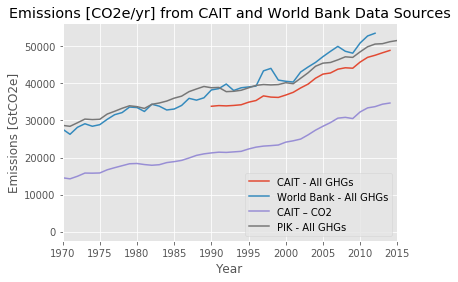

In [17]:
CAIT_world = ghgDf_CAITghg.loc['World',['Year','Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)']]
plt.plot(CAIT_world['Year'].values,CAIT_world.iloc[:,1])

WB_world = ghgDf_WB.loc[['World']].drop(columns='Country Code').melt(var_name='Year')
plt.plot(WB_world.iloc[:,0].astype(int).values,WB_world.iloc[:,1])

CAIT_world_co2 = ghgDf_CAITco2.loc['World']
plt.plot(CAIT_world_co2['Year'].values,CAIT_world_co2.iloc[:,1])

PIK_world = ghgDf_PIK.iloc[:,4:].sum()
plt.plot( PIK_world.index.astype(int) ,PIK_world.values)

plt.xticks(range(1970,2016,5))
plt.xlim([1970,2015])
plt.xlabel('Year')
plt.ylabel('Emissions [GtCO2e]')
plt.title('Emissions [CO2e/yr] from CAIT and World Bank Data Sources')
plt.legend(['CAIT - All GHGs','World Bank - All GHGs','CAIT – CO2','PIK - All GHGs'])

plt.show()

Upon further investigation, these discrepancies are rooted in the different methodologies. Looking deeper in both datasets' sources, they both use CO2 emissions from the International Energy Agency (IEA) but other sources separately too.

* World Bank: Uses IEA and their own independent research ([World Bank Methodology](http://edgar.jrc.ec.europa.eu/methodology.php))
* CAIT: Uses the "IEA source for CO₂ emissions from fossil fuel combustion from 1971 to 2011, and draws the remaining CO₂ and non-CO₂ emissions data from a variety of other sources including CDIAC, U.S. EPA, and FAO." ([CAIT Methodology](http://cait2.wri.org/faq.html))
* PIK: Consolidates many published datasets similar to the above (see section 3.1 of Nabel et al.). ([PIK Methodology](http://dataservices.gfz-potsdam.de/pik/showshort.php?id=escidoc:2959897) | [Nabel et al. (2011)](https://doi.org/10.1016/j.envsoft.2011.08.004))

Typical discrepancies relate to:
* Accounting for biomass emissions (some forms of biomass is treated as 'biogenic' and counted as zero)
* Natural fires and other land-based occurences, which are incredibly difficult to count.

Therefore, going forward, we are going to make

# **_a choice!_**

### Create Comparison for Country Group Codes and Names
The greenhouse gas database provided by the World Bank contains a lot of country aggregates such as middle-income countries, low-income countries, etc. For further analysis, the same World Bank data set with country names and codes introduced above provides a list of these aggregate country codes to provide an index for subsetting and creating a separate dataframe that only contains country data.  

In [18]:
#Import the dataframe which contains the codes of country group aggregates
CountryGroupCodes = pd.read_excel("data/CountryGroups.xls", sheet_name = "List of economies", skiprows=226, header = None)
CountryGroupCodes.dropna(how="all", inplace=True, axis=1)
CountryGroupCodes.drop(columns=0,inplace=True)
CountryGroupCodes.dropna(how="all", inplace=True, axis=0)
CountryGroupCodes.columns = ["Aggregate Name", "Aggregate Code"]
CountryGroupCodes

# Drop the rows corresponding to aggregate country codes from existing dataframe to create a new country dataframe 
ghgCountryDf_WB = ghgDf_WB[ghgDf_WB["Country Code"].apply(lambda x: False if x in CountryGroupCodes["Aggregate Code"].values else True)]

ghgCountryDf_WB.head()

,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,0.042306,0.042787,0.043287,0.043725,0.044131,0.044482,0.131634,0.135055,0.358990,...,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929
Afghanistan,AFG,14.306616,14.391778,13.040848,13.535754,14.945968,14.574164,14.746851,15.247281,15.112318,...,14.709884,14.654374,14.770264,14.849159,15.272633,15.288776,15.554429,17.791330,17.981307,18.168860
Angola,AGO,60.648601,39.162171,42.205651,44.252669,40.179234,44.429300,38.448024,43.563412,46.235115,...,35.858015,36.860233,35.855738,36.375822,36.690534,37.396294,38.309465,40.029392,40.878652,41.657165
Albania,ALB,6.960868,6.950036,7.613266,7.348492,7.632664,7.873037,8.470978,8.948981,9.996056,...,7.834016,7.401102,8.308386,8.027150,9.879394,8.136785,8.108812,8.506996,8.712296,8.898641
United Arab Emirates,ARE,32.962189,41.377845,44.905463,56.875508,57.411527,57.798603,70.352619,69.646400,78.630043,...,134.091686,139.999464,143.367663,151.837320,167.986432,181.388536,182.422169,193.127158,199.342523,204.888719


### Extending World Bank Data with CAIT data on Greenhouse gases
The World Bank data provides the greenshouse gas emissions for all countries only till the year 2012. The Climate Watch dataset (available at https://www.climatewatchdata.org/ghg-emissions?source=31&version=1) provides more recent data on country emissions till the year 2014. 

In this sub-section, we use this dataset (saved as file `CW_CAIT_GHG_Emissions_31102017.xlsx` in the folder data/wri) to extend our original greenshoue dataset for two more years i.e. from 2012 to 2014.

In [19]:
ghgCountryDf_CAIT = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017.xlsx", sheet_name = "GHG Emissions", skiprows = 2, header = None,\
                                 usecols = "A,B,D", names = ["Country", "Year","Total GHG Emissions"])

ghgCountryDf_CAIT[(ghgCountryDf_CAIT["Year"] == 2013) | (ghgCountryDf_CAIT["Year"] == 2014)].head()

,Country,Year,Total GHG Emissions
23,Afghanistan,2013,33.170920
24,Afghanistan,2014,33.366148
48,Albania,2013,8.199265
49,Albania,2014,8.678753
73,Algeria,2013,187.088061


### 1.2 BAU Forecasts

The Climate Watch dataset at https://climatewatchdata.org (maintained by the World Resource Institute and supported by other organizations) includes the Global Change Assessment Model (GCAM), which includes a 'no policy' scenario for global emissions.

The file `GCAM.xlsx` was manually saved into `GCAM.csv`, since only the last sheet was important.

In [20]:
# Use index_col=2, the region, as the index. Drop the Model column, since it is the same across the whole Df.
ghgForecast_GCAM = pd.read_csv('data/wri/Pathways/GCAM.csv', index_col=2).drop(['Model'],axis=1)
ghgForecast_GCAM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15048 entries, Africa_Eastern to World
Data columns (total 14 columns):
Scenario              15048 non-null object
ESP Indicator Name    15048 non-null object
Unit of Entry         15048 non-null object
2005                  15048 non-null float64
2010                  15048 non-null float64
2020                  15048 non-null float64
2030                  15048 non-null float64
2040                  15048 non-null float64
2050                  15048 non-null float64
2060                  15048 non-null float64
2070                  15048 non-null float64
2080                  15048 non-null float64
2090                  15048 non-null float64
2100                  15048 non-null float64
dtypes: float64(11), object(3)
memory usage: 1.7+ MB


Filter the dataset for just the information we're looking for: the 'No policy' scenario and for total GHG emissions. Note that all the emissions are in [MtCO2e/yr] format already.

In [21]:
ghgForecast_GCAM_BAU = \
    ghgForecast_GCAM[ (ghgForecast_GCAM['Scenario'] == 'No policy') &
                    (ghgForecast_GCAM['ESP Indicator Name'].str.startswith('Emissions|GHG')) ] \
                    .loc['World',:]

ghgForecast_GCAM_BAU

,Scenario,ESP Indicator Name,Unit of Entry,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Region,,,,,,,,,,,,,,
World,No policy,Emissions|GHG Emissions by gas with LULUCF|CH4,Mt CO2e/yr,8570.217953,9264.882565,9799.284338,11234.426990,12424.910120,13566.543720,13992.761340,14458.018080,14789.628560,14746.148800,14898.743490
World,No policy,Emissions|GHG Emissions by gas with LULUCF|CO2,Mt CO2e/yr,31889.098990,36595.380740,38754.445630,47492.609340,57088.151610,64566.994840,71211.017950,78084.976450,83450.324940,88192.165270,94373.292260
World,No policy,Emissions|GHG Emissions by gas with LULUCF|F-g...,Mt CO2e/yr,839.939055,892.510385,1489.676138,2451.654059,3068.102671,3707.282410,4371.186662,5042.756627,5673.425213,6191.510868,6579.299866
World,No policy,Emissions|GHG Emissions by gas with LULUCF|N2O,Mt CO2e/yr,1066.793051,1089.492183,1230.369440,1363.312513,1495.367595,1637.717985,1789.992339,1942.661272,2066.852264,2168.403618,2241.209873


In [22]:
print('The total projected GHG emissions for the no policy scenario in 2030 is: {:.2f} MtCO2e/yr.'.format(
    ghgForecast_GCAM_BAU['2030'].sum() ) )

The total projected GHG emissions for the no policy scenario in 2030 is: 62542.00 MtCO2e/yr.


### 1.3 NDCs in 2030

The same ClimateWatch source contains NDCs in the format:

    ISO Country Code, Country Name, Goal Year, Value (in MtCO2e/yr), if goal is a range, and the type of goal.

In [23]:
NDCsDf_raw = pd.read_csv('data/wri/CW_NDC_quantification_April30.csv')
NDCsDf = NDCsDf_raw.dropna(axis=0).drop(328) #328 is a mis-entry, as determined through inspection

# Check data input
NDCsDf.head(5)

,ISO,Country,Year,Value,Range,Label
0,AFG,Afghanistan,2020,35.5,No,BAU
1,AFG,Afghanistan,2025,40.3,No,Conditional
2,AFG,Afghanistan,2025,41.7,No,BAU
3,AFG,Afghanistan,2030,42.7,No,Conditional
4,AFG,Afghanistan,2030,48.9,No,BAU


Some countries' NDCs are given as a range. For simplicity, this analysis will only examine the mean of that range.

In [24]:
rangedIndices = NDCsDf[NDCsDf['Range'] == 'Yes'].index

# Note that each range is a pair
# Is there a non-for loop method to do this?
for i in range(0,len(rangedIndices)-1,2):    
    NDCsDf.loc[rangedIndices[i],'Value'] = (
        (NDCsDf['Value'][rangedIndices[i]] + NDCsDf['Value'][rangedIndices[i+1]])/2
    )
    
# Drop the column 'Range', since it is not really needed anymore,
# and drop the EU-28 (since they have been disaggregated by country).
NDCsDf = NDCsDf.drop(labels=rangedIndices[1::2], axis=0).drop(labels='Range', axis=1)
NDCsDf = NDCsDf.drop(index=NDCsDf.loc[NDCsDf['ISO'] == 'EU28'].index.values, axis=0)

From here on, the situation in 2030 will be the primary focus. Where countries have not submitted data for 2030, the furthest value is used. Furthermore, the best case where the higher goal between choices (e.g. uncondintional if both it and conditional exist) is taken.

Note that the EU, which is collectively a large emitter, has only submitted NDCs for 2020.

In [25]:
NDC_byCountry = []

for i in NDCsDf['ISO'].unique():
    NDC_byCountry.append(NDCsDf[NDCsDf['ISO']==i]['Value'].min() )

In [26]:
d = {
    'Country': NDCsDf['ISO'].unique(),
    'Goal':    NDC_byCountry 
}

NDCs_clean = pd.DataFrame(d)
NDCs_clean = NDCs_clean.set_index('Country')

In [27]:
print('If this best case, where all NDCs are met, then the 2030 emissions will be {:.2f} MtCO2e/yr.' \
     .format( NDCs_clean.values.sum() ))

If this best case, where all NDCs are met, then the 2030 emissions will be 42330.46 MtCO2e/yr.


### 1.4 Emissions Requirements for Temperature Targets

The Intergovernmental Panel on Climate Change (IPCC) recently released a report about emissions pathways required to reach 1.5ºC of warming. They noted that "all but one" model require emissions reduce to *at most 35 GtCO2e/yr by 2030*. Most pathways require at most 50 GtCO2e/yr for 2.0ºC of warming. _(Aashna, source?)-Jason_

IPCC. (2018). IPCC special report on the impacts of global warming of 1.5 °C - Summary for policy makers. Retrieved from http://www.ipcc.ch/report/sr15/

### 1.5 Comparison

Before we can directly compare NDCs to global emissions and targets, we have to filter some data. Not every country has submitted NDCs – as of 2018-10-23, only 177 of 195 UNFCCC members. For those have not yet submitted NDCs, they will be given the benefit of the doubt; the global pathways projections should also filter out the countries that have not yet submitted NDCs.

In [28]:
countryNDCs = NDCsDf['Country'].unique()

# Divide he 'World' values used in the GCAM projection by filtered actual GHG emissions in 2005 and 2010
convFactor = ghgForecast_GCAM[ (ghgForecast_GCAM['Scenario'] == 'No policy') &
                    (ghgForecast_GCAM['ESP Indicator Name'].str.startswith('Emissions|GHG')) ] \
                    .loc['World',['2005','2010']].sum() \
            / ghgDf_CAITghg.pivot(columns='Year',
                  values='Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)') \
                    .loc[countryNDCs,[2005,2010]].sum().values

# Take the average conversion factor between 2005 and 2010
convFactor = convFactor.mean()
convFactor

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


1.5698597009244462

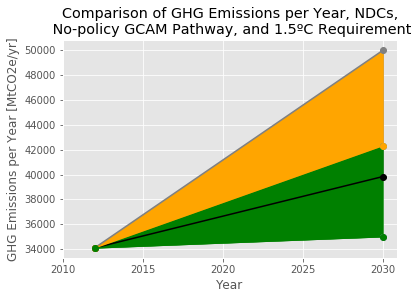

In [29]:
plt.plot(2012,ghgDf_WB.loc['World']['2012']/convFactor,'o',
         2030,NDCs_clean.values.sum(),'o',
        2030,35000,'o')
plt.xticks(range(2010,2031,5))
plt.xlabel('Year')
plt.ylabel('GHG Emissions per Year [MtCO2e/yr]')
plt.title('Comparison of GHG Emissions per Year, NDCs,\n No-policy GCAM Pathway, and 1.5ºC Requirement')
 
x1 = [2012,2030]
y1 = [ghgDf_WB.loc['World']['2012']/convFactor, ghgForecast_GCAM_BAU['2030'].sum()/convFactor]
y2 = [ghgDf_WB.loc['World']['2012']/convFactor, 50000]
y3 = [ghgDf_WB.loc['World']['2012']/convFactor, NDCs_clean.values.sum()]
y4 = [ghgDf_WB.loc['World']['2012']/convFactor, 35000]

CoeffLineNoPolicy = np.polyfit(x1,y1,1)
CoeffLineLowTarget = np.polyfit(x1,y2,1)
CoeffLineNDCs = np.polyfit(x1,y3,1)
CoeffLineHighTarget = np.polyfit(x1,y4,1)

LineNoPolicy = np.poly1d(CoeffLineNoPolicy)
LineLowTarget = np.poly1d(CoeffLineLowTarget)
LineNDCs = np.poly1d(CoeffLineNDCs)
LineHighTarget = np.poly1d(CoeffLineHighTarget)

plt.plot(x1, LineNoPolicy(x1), "-o", color = "black")
plt.plot(x1, LineLowTarget(x1), "-o", color = "grey")
plt.plot(x1, LineNDCs(x1), "-o", color = "orange")
plt.plot(x1, LineHighTarget(x1), "-o", color = "green")

plt.fill_between(x1, LineNoPolicy(x1), LineLowTarget(x1), color = "grey")
plt.fill_between(x1, LineLowTarget(x1), LineNDCs(x1), color = "orange")
plt.fill_between(x1, LineNDCs(x1), LineHighTarget(x1), color = "green")
plt.xticks(range(2010, 2031, 5))
plt.show()


# BREAK IN ANALYSIS

The info below needs to be reorganized. - Jason

### Create Comparison for Country Group Codes and Names

In [30]:
#Import the dataframe which contains the codes of country group aggregates
CountryGroupCodes = pd.read_excel("data/CountryGroups.xls", sheet = "Groups", skiprows=226, header = None)
CountryGroupCodes.dropna(how="all", inplace=True, axis=1)
CountryGroupCodes.drop(columns=0,inplace=True)
CountryGroupCodes.dropna(how="all", inplace=True, axis=0)
CountryGroupCodes.columns = ["Aggregate Name", "Aggregate Code"]
CountryGroupCodes

# Drop the rows corresponding to aggregate country codes from existing dataframe to create a new country dataframe 
ghgCountryDf_WB = ghgDf_WB[ghgDf_WB["Country Code"].apply(lambda x: False if x in CountryGroupCodes["Aggregate Code"].values else True)]

## Data visualization

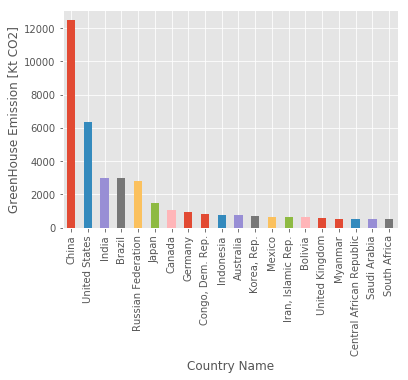

In [31]:
#Sorted bar chart of 2012 greenhouse gases

ghgCountryDf_WB.sort_values(by="2012", ascending=False)["2012"]

GreenhouseGasesTop20Emitters = ghgCountryDf_WB.sort_values(by = "2012", ascending = False).iloc[:20,:]

GreenhouseGasesTop20Emitters["2012"].plot(x = "Country Name", kind="bar")

plt.ylabel("GreenHouse Emission [Kt CO2]")
plt.show()

Time series for greenhouse gases of major (top 10 depending on V1) present polluters (from 1990 to most-recent)

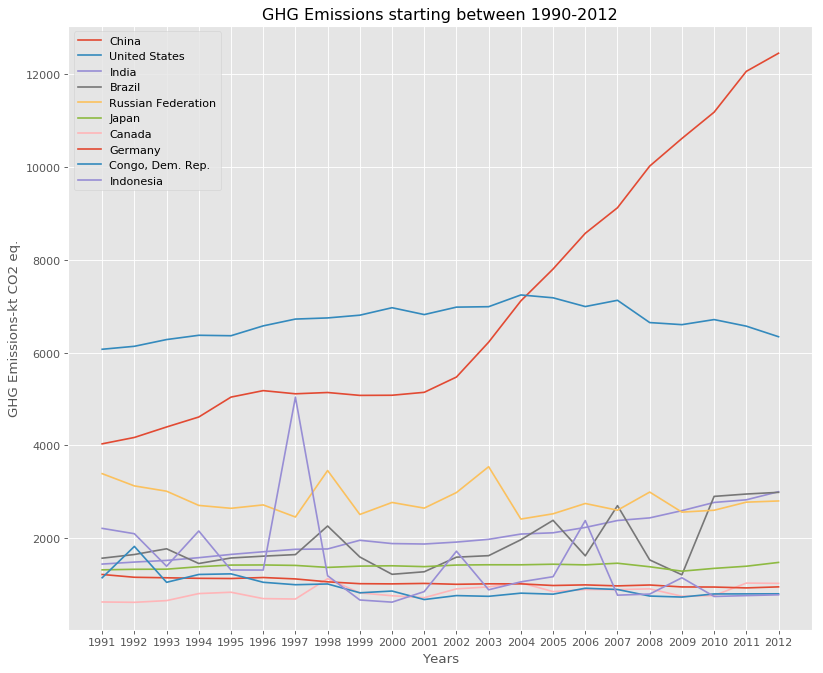

In [32]:
# Time series for ghg emissions of the top 10 most polluting countries.

GreenhouseGasesTop10Emitters = ghgCountryDf_WB.sort_values(by = "2012", ascending = False).iloc[:10,:]

plt.figure(figsize=(12, 10), dpi=80) 

for i in range(0,10):
    
    row = GreenhouseGasesTop10Emitters.iloc[i,22:]
    plt.plot(row)

plt.MaxNLocator(10)
plt.xlabel("Years")
plt.ylabel("GHG Emissions-kt CO2 eq.")
plt.title("GHG Emissions starting between 1990-2012")
#plt.legend(loc=((1.05,0.3)))#how to show country names instead of the numbers 
plt.legend(GreenhouseGasesTop10Emitters.index )

plt.show()

We observe that the top polluter of the world China has increasing emissions starting from 1990s till 2012. The second polluter US, on the other hand shows a stable curve over the years. Until 2004 it is the top polluter of the world. India........

## Data visualization

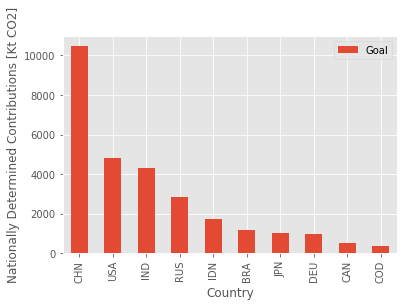

In [33]:
#Greenhouse reductions by countries according to their NDCs. Data is already converted to mtCO2e. Countries have different goals 
#in terms of which year they are based on and which year they aim also unconditional and conditional goals. Here the goals are  
#not based on year target but the minimum goal of each country is choosen?? 

#See if the ones who are most polluting also have the highest reduction aim

GreenhouseGasesTop10Emitters

NDCsTop10 = NDCs_clean.loc[ [i for i in GreenhouseGasesTop10Emitters["Country Code"].values] ]

NDCsTop10.head()

NDCsTop10= NDCsTop10.sort_values(by="Goal", ascending=False)

NDCsTop10.plot(kind="bar")

plt.ylabel("Nationally Determined Contributions [Kt CO2]")
plt.show()

IND-India
IDN-Indonesia
In the first graph we observed that China,US and India are the top 3 major polluters and their reduction targets allign with this ranking. In the greenhouse gases emission graph the list goes on as Brazil, Russia, Japan, Canada, Germany, Congo and Indonesia. Among these countries even though Indonesia is the least polluting among these, it has higher reduction goals than many of the rest of the countries. 